In [63]:
import json
import os
import pandas as pd
import geopandas as gpd
from collections import defaultdict
import matplotlib.pyplot as plt

In [64]:
%matplotlib inline

In [65]:
def get_fichas(path='rodada_5'):
    
    files = [os.path.join(path, file) for file 
            in os.listdir(path) if file.endswith('.json')]
    
    fichas = []
    for file in files:
        with open(file, 'r') as f:
            ficha = json.load(f)
            fichas.append(ficha)
    
    return fichas

In [66]:
def cmap_plot(geodf, col, f_name):

    geodf[col] = geodf[col].apply(lambda x: float(x))
    ax = geodf.plot(column=col, cmap='GnBu',
                    legend=True,
                    figsize=(10, 15),
                    edgecolor='black',
                   vmin=0)


    plt.axis('off')

    fig = ax.get_figure()

    fig.savefig(f_name)

    return fig

In [67]:
class ValorForaPadrao(ValueError):
    '''Raised quando valor está fora do padrão aceitável'''

class MapBuilder:
    
    
    def __init__(self, path_shape_zonas = None, path_mapper_zonas = None, path_salvar = None):
        
        if path_mapper_zonas is None:
            path_mapper_zonas = 'original_data/subs_por_zona.xlsx'
        
        self.mapper_zonas = self.get_sub_zona_mapper(path_mapper_zonas)
        
        if path_shape_zonas is None:
            path_shape_zonas = 'original_data/SIRGAS_SHP_regiao_5/SIRGAS_REGIAO5.shp'
        
        self.shp_zonas = self.abrir_mapas_geosampa(path_shape_zonas)
        self.add_zona_upper()
        
        if path_salvar is None:
            path_salvar = self.solve_path_salvar('mapas_zonas_final')
            
        self.path_salvar = path_salvar
            
    def solve_path_salvar(self, path):
        
        if not os.path.exists(path):
            os.mkdir(path)
        
        return path
        
    def get_sub_zona_mapper(self, path):

        subs_por_zona = pd.read_excel(path)
        lista =  subs_por_zona[['SUBPREFEITURA', 'Região']].to_dict('records')
        dici = {item['SUBPREFEITURA'] : item['Região'] for item in lista}

        return dici
        
    def abrir_mapas_geosampa(self, path):
        
        map_geodf = gpd.read_file(path)
        map_geodf.crs = {'init': 'epsg:31983'}
        map_geodf = map_geodf.to_crs(epsg=4326)

        return map_geodf
    
    def add_zona_upper(self, shp_zonas = None):
        
        if shp_zonas is None:
            shp_zonas = self.shp_zonas
        
        shp_zonas['NOME_UPPER'] = shp_zonas['NOME'].str.upper()
        
        

    def extract_zonas(self, regionalizacao):
        '''Extrai os dados de regionalizacao apenas para as zonas'''

        name_zonas = set(('LESTE', 'NORTE', 'CENTRO', 'OESTE', 'SUL'))
        zonas = [item for item in regionalizacao if 
                item['subprefeitura'] in name_zonas]

        return zonas

    def extract_subs(self, regionalizacao):

        name_zonas = set(('LESTE', 'NORTE', 'CENTRO', 'OESTE', 'SUL'))
        subs = [item for item in regionalizacao if 
                item['subprefeitura'] not in name_zonas]

        return subs

    
    def padronizar_valor(self, val):
        '''Como vamos agregar, estou considerando Null como Zero'''
        
        if pd.isnull(val):
            val = 0
        elif val == '':
            return 0
        elif type(val) in (int, float):
            return val
        try:
            val = float(val)
        except ValueError:
            try:
                val = val.strip()
                val = val.replace('.', '')
                val = val.replace(',', '.')
                val = int(val)
            except Exception as e:
                raise ValorForaPadrao(f'Valor {val} fora do padrão')
                
        return val
    
    def padronizar_valor_verbose(self, valor, meta_num, supress_error = True):
        
        if supress_error:
                try:
                    valor = self.padronizar_valor(valor)
                    return valor
                except ValorForaPadrao as e:
                    print(f'Erro na meta {meta_num}. Valor {valor} fora do padrão')
                    return 0
        else:
            return self.padronizar_valor(valor)
        

    def parse_subs_data(self, ficha, mapper = None, suppress_error = True):

        if mapper is None:
            mapper = self.mapper_zonas
            
        subs = self.extract_subs(ficha['regionalizacao'])
        meta_num = ficha['ficha_tecnica']['numero_meta']

        parsed = defaultdict(int)
        for sub in subs:
            
            zona = mapper[sub['subprefeitura']].upper()
            valor = sub['projecao_quadrienio']
            
            valor_padrao = self.padronizar_valor_verbose(valor, 
                                                           meta_num, suppress_error)
            
            parsed[zona] += valor_padrao

        return parsed

    def parse_zonas_data(self, ficha, suppress_error = True):
        
        zonas = self.extract_zonas(ficha['regionalizacao'])
        meta_num = ficha['ficha_tecnica']['numero_meta']
        parsed = defaultdict(int)
        for zona_dici in zonas:
            zona = zona_dici['subprefeitura']
            valor = zona_dici['projecao_quadrienio']
                              
            valor_padrao = self.padronizar_valor_verbose(valor, 
                                                           meta_num, suppress_error)
            parsed[zona]+=valor_padrao
            
        return parsed
    
    def join_data(self, data):
        
        df = self.shp_zonas.copy()
        
        df['data'] = df['NOME_UPPER'].apply(lambda x: data[x])
        
        return df
    
    def set_file_name(self, ficha, path_salvar = None):
        
        if path_salvar is None:
            path_salvar = self.path_salvar
            
        meta_num = ficha['ficha_tecnica']['numero_meta']
        secretaria = ficha['ficha_tecnica']['secretaria']
        secretaria = secretaria.replace('/', '_')
        
        f_name = f'{secretaria}_{meta_num}'
        f_name = f_name[:10]+'.png'
        
        return os.path.join(path_salvar, f_name)

    
    def plot_data(self, ficha, tipo_dado, suppress_error = True, path_salvar = None):
        
        if tipo_dado not in ('subs', 'zonas'):
            raise ValueError('tipo_dado must be "subs" or "zonas"')
        
        if tipo_dado == 'zonas':
            data = self.parse_zonas_data(ficha, suppress_error = suppress_error)
        else:
            data = self.parse_subs_data(ficha, suppress_error = suppress_error)
            
        df = self.join_data(data)
        
        f_name = self.set_file_name(ficha, path_salvar)
        fig = cmap_plot(df, 'data', f_name)
        
        return fig
        

    def decide_tipo_dado(self, ficha):
        
        zonas = self.parse_zonas_data(ficha)
        
        #checa se tem alguma informação para as zonas
        if sum(zonas.values()) > 0:
            return 'zonas'
        
        return 'subs'
    
    def __call__(self, ficha, suppress_error=True):
        
        tipo_dado = self.decide_tipo_dado(ficha)
        self.plot_data(ficha, tipo_dado, suppress_error)

In [68]:
fichas = get_fichas()

In [69]:
builder = MapBuilder()

In [70]:
ficha = fichas[0]

In [71]:
zonas =  [{'subprefeitura': 'LESTE',
  'projecao_quadrienio': 1,
  'status_regionalizacao': ''},
 {'subprefeitura': 'NORTE',
  'projecao_quadrienio': 1,
  'status_regionalizacao': ''},
 {'subprefeitura': 'CENTRO',
  'projecao_quadrienio': 0,
  'status_regionalizacao': ''},
 {'subprefeitura': 'OESTE',
  'projecao_quadrienio': 0,
  'status_regionalizacao': ''},
 {'subprefeitura': 'SUL',
  'projecao_quadrienio': 2,
  'status_regionalizacao': ''}]

In [72]:
ficha['regionalizacao'] = ficha['regionalizacao'][:-5] + zonas

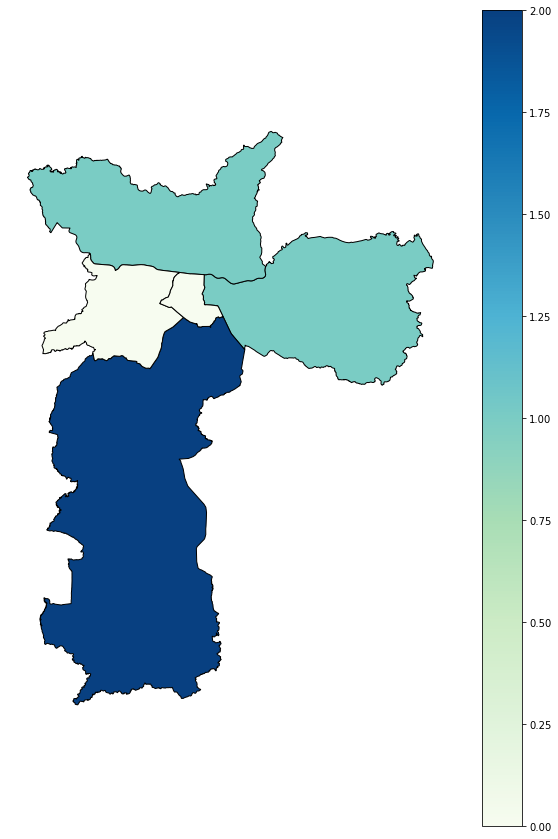

In [73]:
fig = builder.plot_data(ficha, 'zonas')

In [74]:
l = fig.axes[1].get_yticklabels()

In [78]:
a = l[0].get_text()

In [81]:
int(float(a))

0

In [62]:
fig.axes[1].get_yticklabels()

[Text(1, 0.0, '0'),
 Text(1, 0.25, ''),
 Text(1, 0.5, ''),
 Text(1, 0.75, ''),
 Text(1, 1.0, '1'),
 Text(1, 1.25, ''),
 Text(1, 1.5, ''),
 Text(1, 1.75, ''),
 Text(1, 2.0, '2')]